In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def compute_Muller_potential(scale, x):
    A = (-200.0, -100.0, -170.0, 15.0)
    beta = (0.0, 0.0, 11.0, 0.6)
    alpha_gamma = (
        x.new_tensor([-1.0, -10.0]),
        x.new_tensor([-1.0, -10.0]),
        x.new_tensor([-6.5, -6.5]),
        x.new_tensor([0.7, 0.7]),
    )

    ab = (
        x.new_tensor([1.0, 0.0]),
        x.new_tensor([0.0, 0.5]),
        x.new_tensor([-0.5, 1.5]),
        x.new_tensor([-1.0, 1.0]),
    )

    U = 0
    for i in range(4):
        diff = x - ab[i]
        U = U + A[i] * torch.exp(
            torch.sum(alpha_gamma[i] * diff**2, -1) + beta[i] * torch.prod(diff, -1)
        )

    U = scale * U
    return U
def compute_gradient(scale, x):
    # Function to compute the gradient of the Müller-Brown potential
    U = compute_Muller_potential(scale, x)
    grad_U = torch.autograd.grad(U, x, create_graph=True)[0]
    return grad_U

def modified_gibbs_sampling(scale, num_samples, dt, beta, step_size=0.5):
    samples = np.zeros((num_samples, 2))
    x = np.random.normal(0, 1, 2)  # Initial guess for x and y
    x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    U_x = compute_Muller_potential(scale, x_tensor)

    for i in range(num_samples):
        # Compute gradient
        grad_U_x = compute_gradient(scale, x_tensor)

        # Sample y using the adjusted distribution
        mean_y = x[1] - dt * grad_U_x[1].item()
        variance_y = 2 * dt / beta
        y = np.random.normal(mean_y, np.sqrt(variance_y))
        x_y = np.array([x[0], y])
        x_y_tensor = torch.tensor(x_y, dtype=torch.float32, requires_grad=True)
        U_x_y = compute_Muller_potential(scale, x_y_tensor)

        # Accept or reject the new y
        if np.exp(U_x.item() - U_x_y.item()) > np.random.rand():
            x[1] = y
            U_x = U_x_y
            x_tensor = x_y_tensor

        # Sample x using the adjusted distribution
        grad_U_x_y = compute_gradient(scale, x_tensor)
        mean_x = x[0] - dt * grad_U_x_y[0].item()
        variance_x = 2 * dt / beta
        x_new = np.random.normal(mean_x, np.sqrt(variance_x))
        y_x = np.array([x_new, x[1]])
        y_x_tensor = torch.tensor(y_x, dtype=torch.float32, requires_grad=True)
        U_y_x = compute_Muller_potential(scale, y_x_tensor)

        # Accept or reject the new x
        if np.exp(U_x_y.item() - U_y_x.item()) > np.random.rand():
            x[0] = x_new
            U_x = U_y_x

        samples[i] = x

    return samples


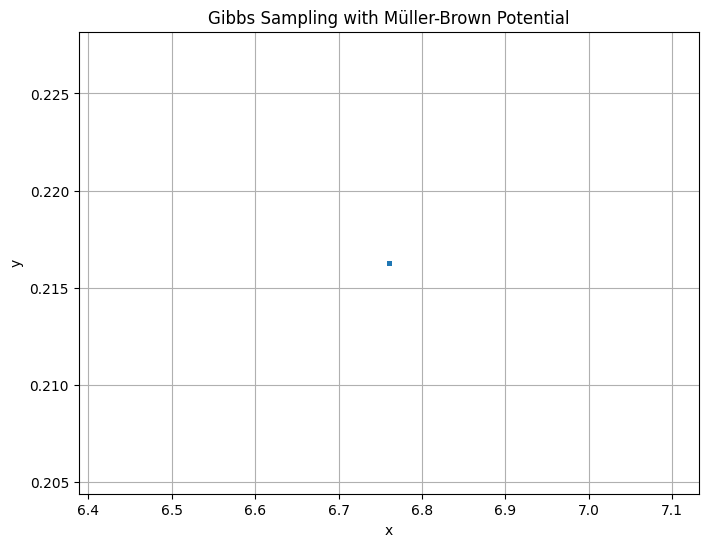

In [6]:
# Perform Gibbs sampling with the Muller-Brown potential
scale = 1.0
num_samples = 1000
samples_with_potential = modified_gibbs_sampling(scale, num_samples, 0.1, 1.0)

# Visualize the samples
plt.figure(figsize=(8, 6))
plt.scatter(samples_with_potential[:, 0], samples_with_potential[:, 1], s=5)
plt.title("Gibbs Sampling with Müller-Brown Potential")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

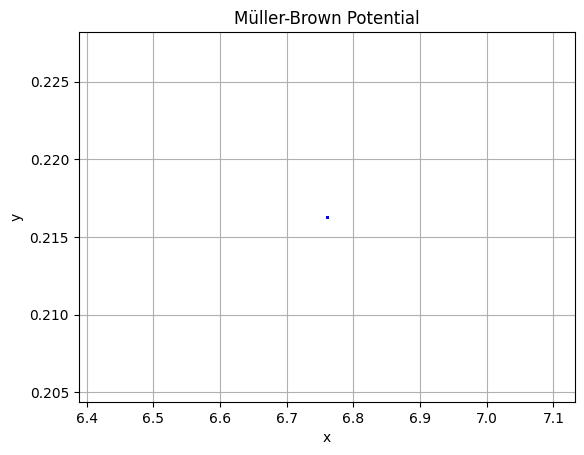

In [7]:
def generate_grid(x1_min, x1_max, x2_min, x2_max, size=100):
    x1 = torch.linspace(x1_min, x1_max, size)
    x2 = torch.linspace(x2_min, x2_max, size)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing="ij")
    grid = torch.stack([grid_x1, grid_x2], dim=-1)
    x = grid.reshape((-1, 2))
    return x


# Maximum and minimun from samples
x1_min, x1_max = np.min(samples_with_potential[:, 0]), np.max(samples_with_potential[:, 0])
x2_min, x2_max = np.min(samples_with_potential[:, 1]), np.max(samples_with_potential[:, 1])
grid_size = 100
x_grid = generate_grid(x1_min, x1_max, x2_min, x2_max, grid_size)
fig, axes = plt.subplots()
scale = 0.05
U = compute_Muller_potential(scale, x_grid)
U = U.reshape(100, 100)
U[U > 9] = 9
U = U.T
plt.contourf(
    U,
    levels=np.linspace(-9, 9, 19),
    extent=(x1_min, x1_max, x2_min, x2_max),
    cmap="viridis_r",
)
plt.scatter(samples_with_potential[:, 0], samples_with_potential[:, 1], s=1, color='blue')
plt.title('Müller-Brown Potential')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

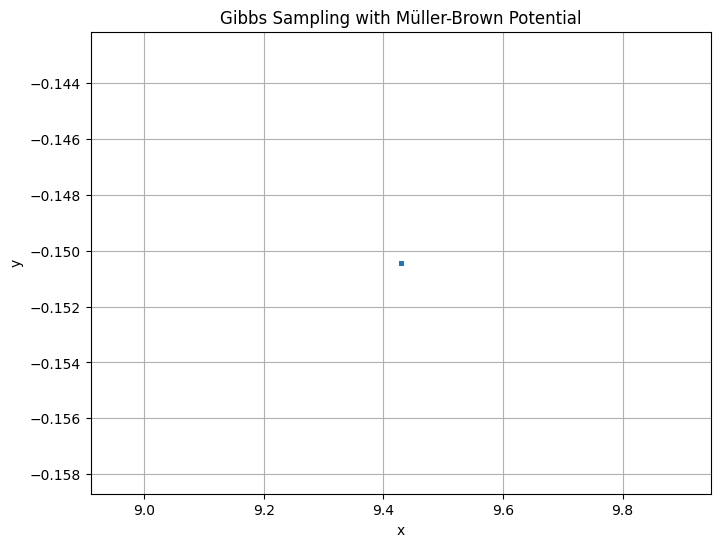

In [8]:
# Perform Gibbs sampling with the Muller-Brown potential
scale = 1.0
num_samples = 100000
samples_with_potential = modified_gibbs_sampling(scale, num_samples, 0.1, 1.0)

# Visualize the samples
plt.figure(figsize=(8, 6))
plt.scatter(samples_with_potential[:, 0], samples_with_potential[:, 1], s=5)
plt.title("Gibbs Sampling with Müller-Brown Potential")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

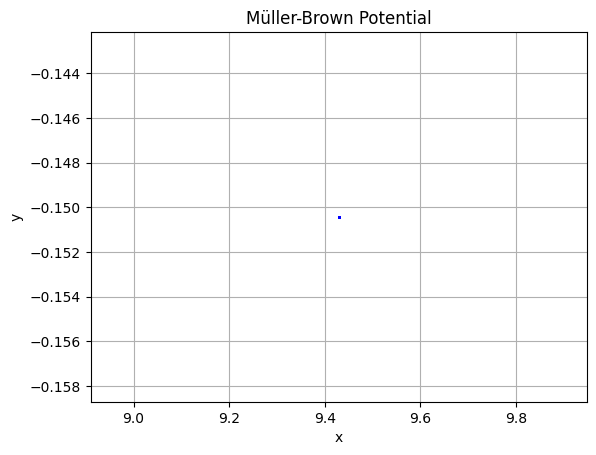

In [9]:
def generate_grid(x1_min, x1_max, x2_min, x2_max, size=100):
    x1 = torch.linspace(x1_min, x1_max, size)
    x2 = torch.linspace(x2_min, x2_max, size)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing="ij")
    grid = torch.stack([grid_x1, grid_x2], dim=-1)
    x = grid.reshape((-1, 2))
    return x


# Maximum and minimun from samples
x1_min, x1_max = np.min(samples_with_potential[:, 0]), np.max(samples_with_potential[:, 0])
x2_min, x2_max = np.min(samples_with_potential[:, 1]), np.max(samples_with_potential[:, 1])
grid_size = 100
x_grid = generate_grid(x1_min, x1_max, x2_min, x2_max, grid_size)
fig, axes = plt.subplots()
scale = 0.05
U = compute_Muller_potential(scale, x_grid)
U = U.reshape(100, 100)
U[U > 9] = 9
U = U.T
plt.contourf(
    U,
    levels=np.linspace(-9, 9, 19),
    extent=(x1_min, x1_max, x2_min, x2_max),
    cmap="viridis_r",
)
plt.scatter(samples_with_potential[:, 0], samples_with_potential[:, 1], s=1, color='blue')
plt.title('Müller-Brown Potential')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

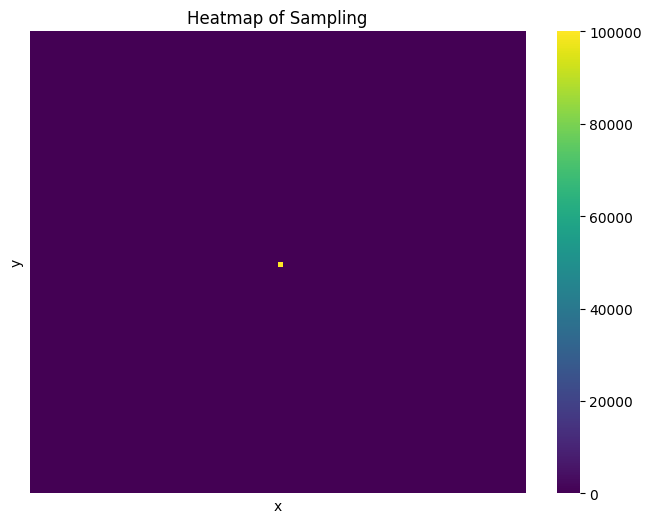

In [10]:
# Create a dataframe from the samples
df_samples = pd.DataFrame(samples_with_potential, columns=['x', 'y'])

# Create a 2D histogram of the samples
heatmap, xedges, yedges = np.histogram2d(df_samples['x'], -df_samples['y'], bins=100)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap.T, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Heatmap of Sampling')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


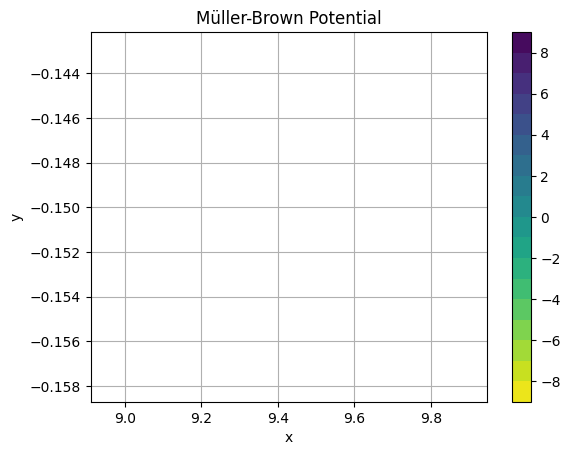

In [11]:

# Maximum and minimun from samples
x1_min, x1_max = np.min(samples_with_potential[:, 0]), np.max(samples_with_potential[:, 0])
x2_min, x2_max = np.min(samples_with_potential[:, 1]), np.max(samples_with_potential[:, 1])
grid_size = 100
x_grid = generate_grid(x1_min, x1_max, x2_min, x2_max, grid_size)
fig, axes = plt.subplots()
scale = 0.05
U = compute_Muller_potential(scale, x_grid)
U = U.reshape(100, 100)
U[U > 9] = 9
U = U.T
plt.contourf(
    U,
    levels=np.linspace(-9, 9, 19),
    extent=(x1_min, x1_max, x2_min, x2_max),
    cmap="viridis_r",
)
plt.title('Müller-Brown Potential')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()